In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
from sys import getsizeof
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.preprocessing import LabelEncoder
from IPython.display import clear_output
import os
import time
from sklearn.model_selection import train_test_split
path="/its/home/drs25/Documents/GitHub/RoboSkin/Code/NewRigExperiments/"
datapath="/its/home/drs25/Documents/data/Tactile Dataset/datasets/"
if os.name == 'nt':
    path="C:/Users/dexte/github/RoboSkin/Code/NewRigExperiments/"
    datapath="C:/Users/dexte/github/RoboSkin/Code/NewRigExperiments/texture-tactip/"
from IPython.display import clear_output
#os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:18230"
from sklearn.linear_model import Ridge
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device=torch.device("cpu")
print(f"Using device: {device}")
from itertools import islice

def take(n, iterable):
    """Return the first n items of the iterable as a list."""
    return list(islice(iterable, n))


Using device: cuda


# load in datasets

In [2]:
class loaded:
    def __init__(self,t=20,filename="X_data_15.npz"):
        data = np.load(datapath+filename) #load data
        for array_name in data:
            self.X=(data[array_name].astype(np.uint8))
        data = np.load(datapath+filename.replace("X","y")) #load data
        for array_name in data:
            self.y=(data[array_name].astype(np.uint8))
        self.keys=['Leather', 'Cork', 'wool', 'LacedMatt', 'Gfoam', 'Plastic', 'Carpet', 'bubble', 'Efoam', 'cotton', 'LongCarpet', 'Flat', 'felt', 'Jeans', 'Ffoam']

        print("Dataset size:",self.X.shape[0],"\nWindow size:",self.X.shape[1],"\nImage:",self.X.shape[2:])
        print("Memory needed:",round(getsizeof(self.X)/ 1024 / 1024/ 1024,2),"GB")
        assert self.X.shape[0]==self.y.shape[0],"Incorrect data size match y="+str(self.y.shape[0])+" x="+str(self.X.shape[0])
        self.X=self.X[:,0:t]
        #randomize order
        n_samples = self.X.shape[0]
        indices = np.random.permutation(n_samples)
        shuffled_data = self.X[indices]
        shuffled_labels = self.y[indices]
        self.X=shuffled_data
        self.y=shuffled_labels
    def shuffle(self):
        n_samples = self.X.shape[0]
        indices = np.random.permutation(n_samples)
        shuffled_data = self.X[indices]
        shuffled_labels = self.y[indices]
        self.X=shuffled_data
        self.y=shuffled_labels
    def augment(self):
        #create rotations
        self.AugmentedX=np.zeros((len(self.X)*3,*self.X.shape[1:]),dtype=np.uint8)
        self.Augmentedy=np.zeros_like(np.concatenate((self.y,self.y,self.y)))
        for k,i in enumerate(range(0,len(self.AugmentedX),3)): #loop through the normal data and new data
            for j in range(len(self.X[0])):
                self.AugmentedX[i][j]=np.copy(self.X[k][j])
                self.AugmentedX[i+1][j]=cv2.resize(cv2.rotate(self.X[k][j].copy(), cv2.ROTATE_90_CLOCKWISE),(self.X[k][j].shape[1],self.X[k][j].shape[0]),interpolation=cv2.INTER_AREA)
                self.AugmentedX[i+2][j]=cv2.resize(cv2.rotate(self.X[k][j].copy(), cv2.ROTATE_180),(self.X[k][j].shape[1],self.X[k][j].shape[0]),interpolation=cv2.INTER_AREA)
                self.Augmentedy[i+1]=self.y[k]
                self.Augmentedy[i+2]=self.y[k]
                self.Augmentedy[i]=self.y[k]
                #self.AugmentedX[i+3][j]=cv2.rotate(self.X[k][j], cv2.ROTATE_90_COUNTERCLOCKWISE)
        print("Dataset size:",self.AugmentedX.shape[0],"\nWindow size:",self.X.shape[1],"\nImage:",self.X.shape[2:])
        print("Memory needed:",round(getsizeof(self.AugmentedX)/ 1024 / 1024/ 1024,2),"GB")
        self.X = self.AugmentedX
        self.y = self.Augmentedy
        n_samples = self.X.shape[0]
        indices = np.random.permutation(n_samples)
        shuffled_data = self.X[indices]
        shuffled_labels = self.y[indices]
        self.X=shuffled_data
        self.y=shuffled_labels
        del self.AugmentedX
        del self.Augmentedy
    def applySobel(self):
        for i in range(len(self.X)): #crop all images individually
            for j in range(len(self.X[0])):
                image=self.X[i][j]
                # Apply Sobel filter in x-direction
                sobel_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)  # ksize=3 for a 3x3 Sobel kernel

                # Apply Sobel filter in y-direction
                sobel_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)

                # Convert the results back to uint8
                sobel_x = np.uint8(np.absolute(sobel_x))
                sobel_y = np.uint8(np.absolute(sobel_y))

                # Combine the results to get the final edge-detected image
                sobel_combined = cv2.bitwise_or(sobel_x, sobel_y)
                self.X[i][j]=sobel_combined

    def resize(self,percentage):
        h=int(self.X.shape[2]*percentage)
        w=int(self.X.shape[3]*percentage)
        new_array=np.zeros((*self.X.shape[0:2],h,w))

        for i in range(len(self.X)): #crop all images individually
            for j in range(len(self.X[0])):
                image=self.X[i][j]
                iamge = cv2.resize(image,(w,h),interpolation=cv2.INTER_AREA)
                new_array[i][j]=iamge
        self.X=new_array.copy()
#data=loaded(t=13)
#data.applySobel()
#data.augment()

# convert data labels to friction 

In [3]:
data=loaded(t=4)
data.applySobel()
#data.augment()

Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB


In [4]:
data_ = np.load(datapath+"X_data_presstip.npz") #load data
X=None
for array_name in data_:
    X=data_[array_name]
X=(X* 3.3) / 65536 #convert to voltage
data_ = np.load(datapath+"y_data_presstip.npz") #load data
y=None
for array_name in data_:
    y=data_[array_name]
print(X.shape,y.shape)


(3000, 20, 16) (3000,)


In [5]:
def relabel(d):
    global friction_dict
    the_ys=d.copy().astype(np.float64)
    labels = [
        "ffoam", "flat", "plastic", "leather", "cork", 
        "longcarpet", "carpet", "gfoam", "efoam", 
        "lacedmatt", "jeans", "wool", "bubble", "felt", "cotton"
    ]

    # Corresponding friction values
    values = [
        0.923363636363636, 0.383908045977011, 0.354716981132075, 
        0.951428571428571, 0.642957746478873, 0.484507042253521, 
        0.323076923076923, 0.5125, 0.383787878787879, 0.37453125, 
        0.444262295081967, 0.2945, 0.484745762711864, 0.533898305084746, 
        0.6745
    ]

    # Creating the dictionary
    friction_dict = dict(zip(labels, values))
    friction_dict
    keys=[x.lower() for x in data.keys]
    for i in range(len(keys)):
        friction=friction_dict[keys[i]]
        the_ys[np.where(the_ys==i)[0]]=friction
    return the_ys
data.y=relabel(data.y)
y=relabel(y)

# modelling

## regression

In [28]:
#tactip
alpha = 0.5  # Regularization parameter
# Fit and transform the label data
X_train, X_test, y_train, y_test = train_test_split(data.X.reshape((len(data.X),-1)),data.y, test_size=0.2, random_state=42)
# Define the Ridge regression model
ridge_model = Ridge(alpha=alpha)
ridge_model.fit(X_train, y_train)
predictions = ridge_model.predict(X_test)
a=np.round(predictions,1)-np.round(y_test,1)
correct=len(a[a==0])
print("Accuracy",correct/len(a)*100,"%")
print("average loss",np.sum(np.absolute(predictions-y_test))/len(predictions))


Accuracy 42.833333333333336 %
average loss 0.00795923870613888


In [9]:
#test res
alpha=0.5
resolutions=[0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.7,0.8,0.9,1]
acc_test=[]
acc_train=[]
loss_test=[]
loss_train=[]

for i, res in enumerate(resolutions):
    #load data
    data=loaded(t=4)
    data.applySobel()
    data.resize(res)
    data.y=relabel(data.y)
    X_train, X_test, y_train, y_test = train_test_split(data.X.reshape((len(data.X),-1)),data.y, test_size=0.2, random_state=42)
    # Define the Ridge regression model
    ridge_model = Ridge(alpha=alpha)
    ridge_model.fit(X_train, y_train)
    predictions = ridge_model.predict(X_test)
    a=np.round(predictions,1)-np.round(y_test,1)
    correct=len(a[a==0])
    acc_test.append(correct/len(a)*100)
    loss_test.append(np.sum(np.absolute(predictions-y_test))/len(predictions))
    predictions = ridge_model.predict(X_train)
    a=np.round(predictions,1)-np.round(y_train,1)
    correct=len(a[a==0])
    acc_train.append(correct/len(a)*100)
    loss_train.append(np.sum(np.absolute(predictions-y_train))/len(predictions))

    print("Accuracy",correct/len(a)*100,"%")
    
    np.save(path+"data/acc_test_regression_friction_"+str(res).replace(".","-"),np.array(acc_test))
    np.save(path+"data/acc_train_regression_friction_"+str(res).replace(".","-"),np.array(acc_train))
    np.save(path+"data/loss_test_regression_friction_"+str(res).replace(".","-"),np.array(loss_test))
    np.save(path+"data/loss_train_regression_friction_"+str(res).replace(".","-"),np.array(loss_train))


Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Accuracy 52.416666666666664 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Accuracy 79.25 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Accuracy 87.29166666666667 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Accuracy 93.66666666666667 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Accuracy 100.0 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Accuracy 100.0 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Accuracy 100.0 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Accuracy 100.0 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Accuracy 100.0 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Accuracy 100.0 %
Dataset size:

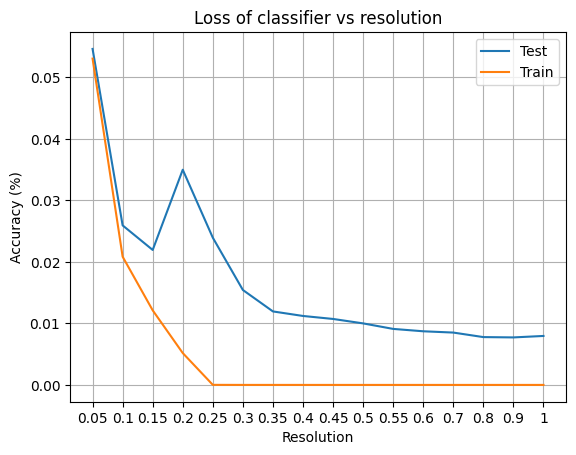

In [15]:
#plt.plot(acc_test,label="Test")
#plt.plot(acc_train,label="Train")
plt.plot(loss_test,label="Test")
plt.plot(loss_train,label="Train")
plt.legend()
plt.grid(True)
plt.title("Loss of classifier vs resolution")
plt.ylabel("Accuracy (%)")
plt.xlabel("Resolution")
plt.xticks([i for i in range(len(acc_train))],resolutions)
plt.savefig(path+"/images/resolutionfrictionloss.pdf")
plt.show()

In [26]:
# presstip
alpha = 0.5  # Regularization parameter
# Fit and transform the label data
piezoeelectric=X[:,8]
accelerometer=X[:,9:12]
both=X[:,8:12]
X_train, X_test, y_train, y_test = train_test_split(piezoeelectric.reshape((len(X),-1)),y, test_size=0.2, random_state=42)
# Define the Ridge regression model
ridge_model = Ridge(alpha=alpha)
ridge_model.fit(X_train, y_train)
predictions = ridge_model.predict(X_test)
a=np.round(predictions,1)-np.round(y_test,1)
correct=len(a[a==0])
print("Accuracy",correct/len(a)*100,"%")
print("average loss",np.sum(np.absolute(predictions-y_test))/len(predictions))


Accuracy 23.166666666666664 %
average loss 0.14115648097314656


/tmp/ipykernel_3929/1392950122.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colours = plt.cm.get_cmap('tab20', 15).colors  # 15 distinct colors for the 15 materials
/tmp/ipykernel_3929/1392950122.py:10: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(predictions[i],y_test[i],c=colours[dict_[class_]],label=class_)
/tmp/ipykernel_3929/1392950122.py:8: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches wi

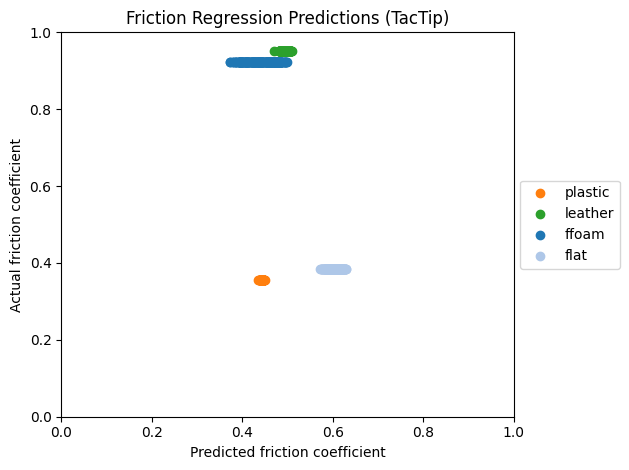

In [51]:

reveresed={np.round(v,5): k for k, v in friction_dict.items()}
colours = plt.cm.get_cmap('tab20', 15).colors  # 15 distinct colors for the 15 materials
dict_={v[1]: i for i,v in enumerate(reveresed.items())}
found=[]
for i in range(len(y_test)):
    class_=reveresed[np.round(y_test[i],5)]
    if class_ in found:
        plt.scatter(predictions[i],y_test[i],c=colours[dict_[class_]])
    else:
        plt.scatter(predictions[i],y_test[i],c=colours[dict_[class_]],label=class_)
        found.append(class_)


plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("Friction Regression Predictions (TacTip)")
plt.xlabel("Predicted friction coefficient")
plt.ylabel("Actual friction coefficient")
plt.xlim([0,1])
plt.ylim([0,1])
plt.tight_layout()  # Adds space on the right for the legend
plt.savefig(path+"/images/friction_optical_unseen.pdf")
plt.show()

### take out some textures

In [50]:
#tactip
alpha = 0.5  # Regularization parameter
# Fit and transform the label data
reveresed_segment={np.round(v,5): k for k, v in take(4,friction_dict.items())}
new_dataX=[]
old_dataX=[]
new_datay=[]
old_datay=[]
for i in range(len(data.X)):
    if np.round(data.y[i],5) in list(reveresed_segment.keys()):
        new_datay.append(data.y[i])
        new_dataX.append(data.X[i])

    else:
        old_datay.append(data.y[i])
        old_dataX.append(data.X[i])

new_dataX=np.array(new_dataX)
new_datay=np.array(new_datay)
old_dataX=np.array(old_dataX)
old_datay=np.array(old_datay)
print(new_dataX.shape,old_dataX.shape)
new_dataX=new_dataX.reshape(len(new_dataX),-1)
old_dataX=old_dataX.reshape(len(old_dataX),-1)
# Define the Ridge regression model
ridge_model = Ridge(alpha=alpha)
ridge_model.fit(old_dataX, old_datay)
predictions = ridge_model.predict(new_dataX)
a=np.round(predictions,1)-np.round(new_datay,1)
correct=len(a[a==0])
print("Accuracy",correct/len(a)*100,"%")
print("average loss",np.sum(np.absolute(predictions-new_datay))/len(predictions))
y_test=new_datay

(800, 4, 110, 120) (2200, 4, 110, 120)
Accuracy 25.0 %
average loss 0.31186350046694505


## neural


In [35]:
class ANN(nn.Module):
    def __init__(self, num_inputs, hidden_size, num_outputs):
        super(ANN, self).__init__()
        
        # Define the layers: input to hidden, and hidden to output
        self.fc1 = nn.Linear(num_inputs, hidden_size)  # Fully connected layer (input -> hidden)
        self.relu = nn.ReLU()  # ReLU activation function
        self.fc2 = nn.Linear(hidden_size, 100)  # Fully connected layer (hidden -> output)
        self.fc3 = nn.Linear(100, num_outputs)
    def forward(self, x):
        # Forward pass: input -> hidden -> output
        out = self.fc1(x)
        out = self.relu(out)  # Apply ReLU to hidden layer output
        out = self.fc2(out)
        out = self.relu(out)  # Apply ReLU to hidden layer output
        out = self.fc3(out)
        return out
class CNN(nn.Module):
    def __init__(self,input_height, input_width,output=15):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 10, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        self.flatten_size = 10 * (input_height // 4) * (input_width // 4)
        
        self.fc1 = nn.Linear(self.flatten_size, 128)
        self.fc2 = nn.Linear(128, output)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(x.size(0), self.flatten_size)  # Flatten the tensor
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x
def train_model(model, criterion, optimizer, train_loader, num_epochs=100):
    loss_history=[]
    for epoch in range(num_epochs):
        for i, (inputs, targets) in enumerate(train_loader):
            # Forward pass
            outputs = model(inputs.float())
            loss = criterion(outputs, targets.float())  # Calculate loss
            
            # Backward pass and optimization
            optimizer.zero_grad()  # Zero the gradients before backward pass
            loss.backward()  # Backpropagate the loss
            optimizer.step()  # Update the model parameters
        loss_history.append(loss.item())
        # Print loss for every 10 epochs
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
    
    print('Training complete')
    return model, loss_history
def run(x_,y_,model,num_epochs=100,loss=nn.MSELoss()):
    X_train, X_test, y_train, y_test = train_test_split(x_,y_, test_size=0.2, random_state=42)
    train_dataset = TensorDataset(X_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

    criterion = loss  # Mean Squared Error for regression tasks
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    model,history=train_model(model, criterion, optimizer, train_loader, num_epochs=num_epochs)
    del train_dataset
    del train_loader
    predictions = model(X_test.float())
    if predictions.shape[1]>1:
        a=np.round(torch.argmax(predictions,axis=1).cpu().detach().numpy().flatten(),1)-np.round(torch.argmax(y_test,axis=1).cpu().detach().numpy(),1)
    else:
        a=np.round(predictions.cpu().detach().numpy().flatten(),1)-np.round(y_test.cpu().detach().numpy(),1)

    correct=len(a[a==0])
    print("Accuracy",correct/len(a)*100,"%")
    print("average loss",torch.sum(torch.absolute(predictions-y_test))/len(predictions))
    plt.plot(history)
    plt.show()

### optical
#### ann

c:\Users\dexte\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\dexte\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [10/100], Loss: 0.0336
Epoch [20/100], Loss: 0.0254
Epoch [30/100], Loss: 0.0322
Epoch [40/100], Loss: 0.0352
Epoch [50/100], Loss: 0.0260
Epoch [60/100], Loss: 0.0441
Epoch [70/100], Loss: 0.0409
Epoch [80/100], Loss: 0.0530
Epoch [90/100], Loss: 0.0475
Epoch [100/100], Loss: 0.0532
Training complete
Accuracy 25.61111111111111 %
average loss tensor(256.6247, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


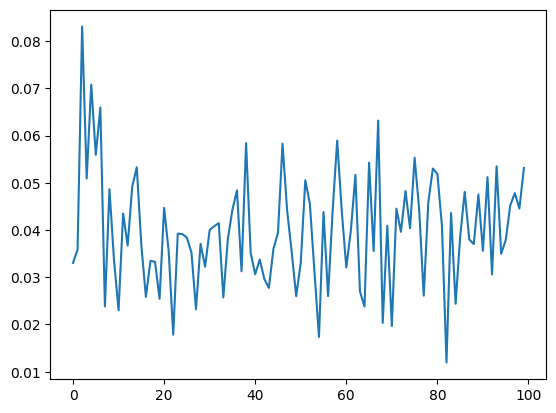

In [36]:
#trasnsfer learning
"""data=loaded(t=4)
data.applySobel()
x_=torch.tensor(data.X.reshape((len(data.X),-1))).to(device)
x_=(x_-torch.min(x_))/(torch.max(x_)-torch.min(x_)) 
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(data.y)
one_hot_labels = torch.nn.functional.one_hot(torch.tensor(train_labels_encoded), num_classes=len(np.unique(train_labels_encoded)))
y_=torch.tensor(one_hot_labels).to(device)

model=ANN(len(x_[0]),1000,15).to(device)
criterion = nn.CrossEntropyLoss().to(device)
run(x_,y_,model,num_epochs=100,loss=criterion)"""

"""data=loaded(t=4)
data.applySobel()
data.augment()
data.y=relabel(data.y)"""
x_=torch.tensor(data.X.reshape((len(data.X),-1))).to(device)
x_=(x_-torch.min(x_))/(torch.max(x_)-torch.min(x_)) 
y_=torch.tensor(np.round(data.y,1)).to(device)

modelB=ANN(len(x_[0]),1000,1).to(device)
#modelB.fc1=model.fc1
#modelB.fc2=model.fc2
run(x_,y_,modelB)
del x_
del y_


#### cnn

c:\Users\dexte\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\dexte\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [10/100], Loss: 0.0362
Epoch [20/100], Loss: 0.0607
Epoch [30/100], Loss: 0.0375
Epoch [40/100], Loss: 0.0256
Epoch [50/100], Loss: 0.0450
Epoch [60/100], Loss: 0.0480
Epoch [70/100], Loss: 0.0300
Epoch [80/100], Loss: 0.0380
Epoch [90/100], Loss: 0.0390
Epoch [100/100], Loss: 0.0658
Training complete
Accuracy 27.333333333333332 %
average loss tensor(89.0364, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


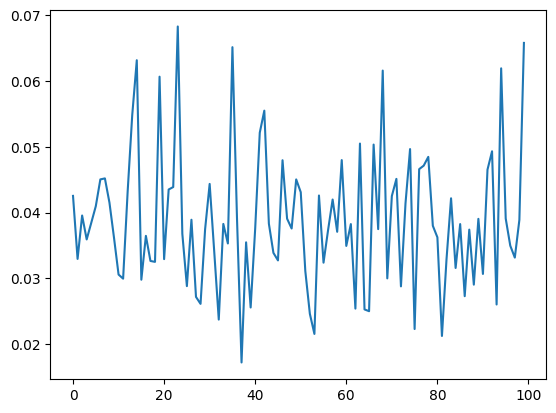

In [8]:
torch.cuda.empty_cache()
x_=torch.tensor(data.X.reshape((len(data.X),1,data.X.shape[2]*data.X.shape[1],data.X.shape[3]))).to(device)
x_=(x_-torch.min(x_))/(torch.max(x_)-torch.min(x_)) 
y_=torch.tensor(data.y).to(device)


model=CNN(x_.shape[2],x_.shape[3],1).to(device)
run(x_,y_,model)
del x_
del y_


### electric

Epoch [10/500], Loss: 0.0282
Epoch [20/500], Loss: 0.0322
Epoch [30/500], Loss: 0.0449
Epoch [40/500], Loss: 0.0362
Epoch [50/500], Loss: 0.0445
Epoch [60/500], Loss: 0.0162
Epoch [70/500], Loss: 0.0483
Epoch [80/500], Loss: 0.0253
Epoch [90/500], Loss: 0.0361
Epoch [100/500], Loss: 0.0264
Epoch [110/500], Loss: 0.0328
Epoch [120/500], Loss: 0.0500
Epoch [130/500], Loss: 0.0396
Epoch [140/500], Loss: 0.0341
Epoch [150/500], Loss: 0.0719
Epoch [160/500], Loss: 0.0592
Epoch [170/500], Loss: 0.0184
Epoch [180/500], Loss: 0.0091
Epoch [190/500], Loss: 0.0153
Epoch [200/500], Loss: 0.0552
Epoch [210/500], Loss: 0.0264
Epoch [220/500], Loss: 0.0297
Epoch [230/500], Loss: 0.0441
Epoch [240/500], Loss: 0.0232
Epoch [250/500], Loss: 0.0543
Epoch [260/500], Loss: 0.0392
Epoch [270/500], Loss: 0.0298
Epoch [280/500], Loss: 0.0343
Epoch [290/500], Loss: 0.0103
Epoch [300/500], Loss: 0.0589
Epoch [310/500], Loss: 0.0232
Epoch [320/500], Loss: 0.0672
Epoch [330/500], Loss: 0.0466
Epoch [340/500], Lo

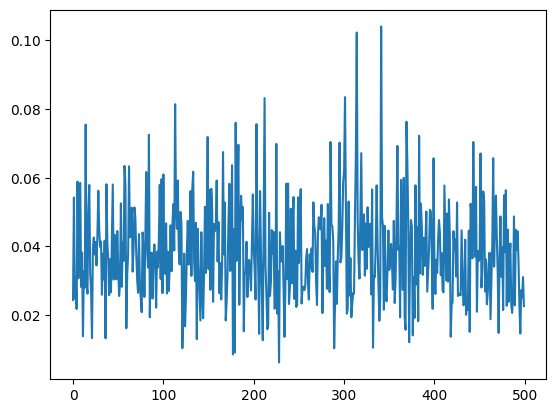

In [89]:
piezoeelectric=X[:,8]
accelerometer=X[:,9:12]
both=X[:,8:12]
x_=torch.tensor(piezoeelectric.reshape((len(X),-1)))
y_=torch.tensor(y)
X_train, X_test, y_train, y_test = train_test_split(x_,y_, test_size=0.2, random_state=42)

model=ANN(len(x_[0]),1000,1)
del x_
del y_

train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

criterion = nn.MSELoss()  # Mean Squared Error for regression tasks
optimizer = optim.SGD(model.parameters(), lr=0.001)

model,history=train_model(model, criterion, optimizer, train_loader, num_epochs=500)
predictions = model(X_test.float())

a=np.round(predictions.cpu().detach().numpy().flatten(),1)-np.round(y_test.cpu().detach().numpy(),1)

correct=len(a[a==0])
print("Accuracy",correct/len(a)*100,"%")
print("average loss",torch.sum(torch.absolute(predictions-y_test))/len(predictions))
plt.plot(history)
plt.show()

Accuracy 27.500000000000004 %
average loss tensor(86.5181, dtype=torch.float64, grad_fn=<DivBackward0>)
